In [2]:
pip install memory-profiler

 STARTING QUICK BENCHMARK WITH PLOTS

 BENCHMARKING 1,000 SAMPLES 
 LINEAR REGRESSION BENCHMARK (1,000 samples)

1.  DUCKDB BUILT-IN FUNCTIONS
--------------------------------------------------
   Slope: 2.469043 (true: 2.5)
   Intercept: 1.349561 (true: 1.0)
   R²: 0.930204
   Time: 0.137485 seconds (137.485 μs/sample)
   Memory: 263.96 MB

2.  NUMPY MANUAL CALCULATION
--------------------------------------------------
   Slope: 2.469043
   Intercept: 1.349561
   R²: 0.930204
   Time: 0.239545 seconds (239.545 μs/sample)
   Memory: 263.66 MB

3.  NUMPY WITH BUILT-IN FUNCTIONS
--------------------------------------------------
   Slope: 2.469043
   Intercept: 1.349561
   R²: 0.930204
   Time: 0.176778 seconds (176.778 μs/sample)
   Memory: 263.85 MB

4.  COMPARISON RESULTS
--------------------------------------------------
    DuckDB vs NumPy (manual): 1.74x faster
    DuckDB vs NumPy (built-in): 1.29x faster
    DuckDB vs NumPy (manual): 1.00x less memory
    DuckDB vs NumPy (built-in

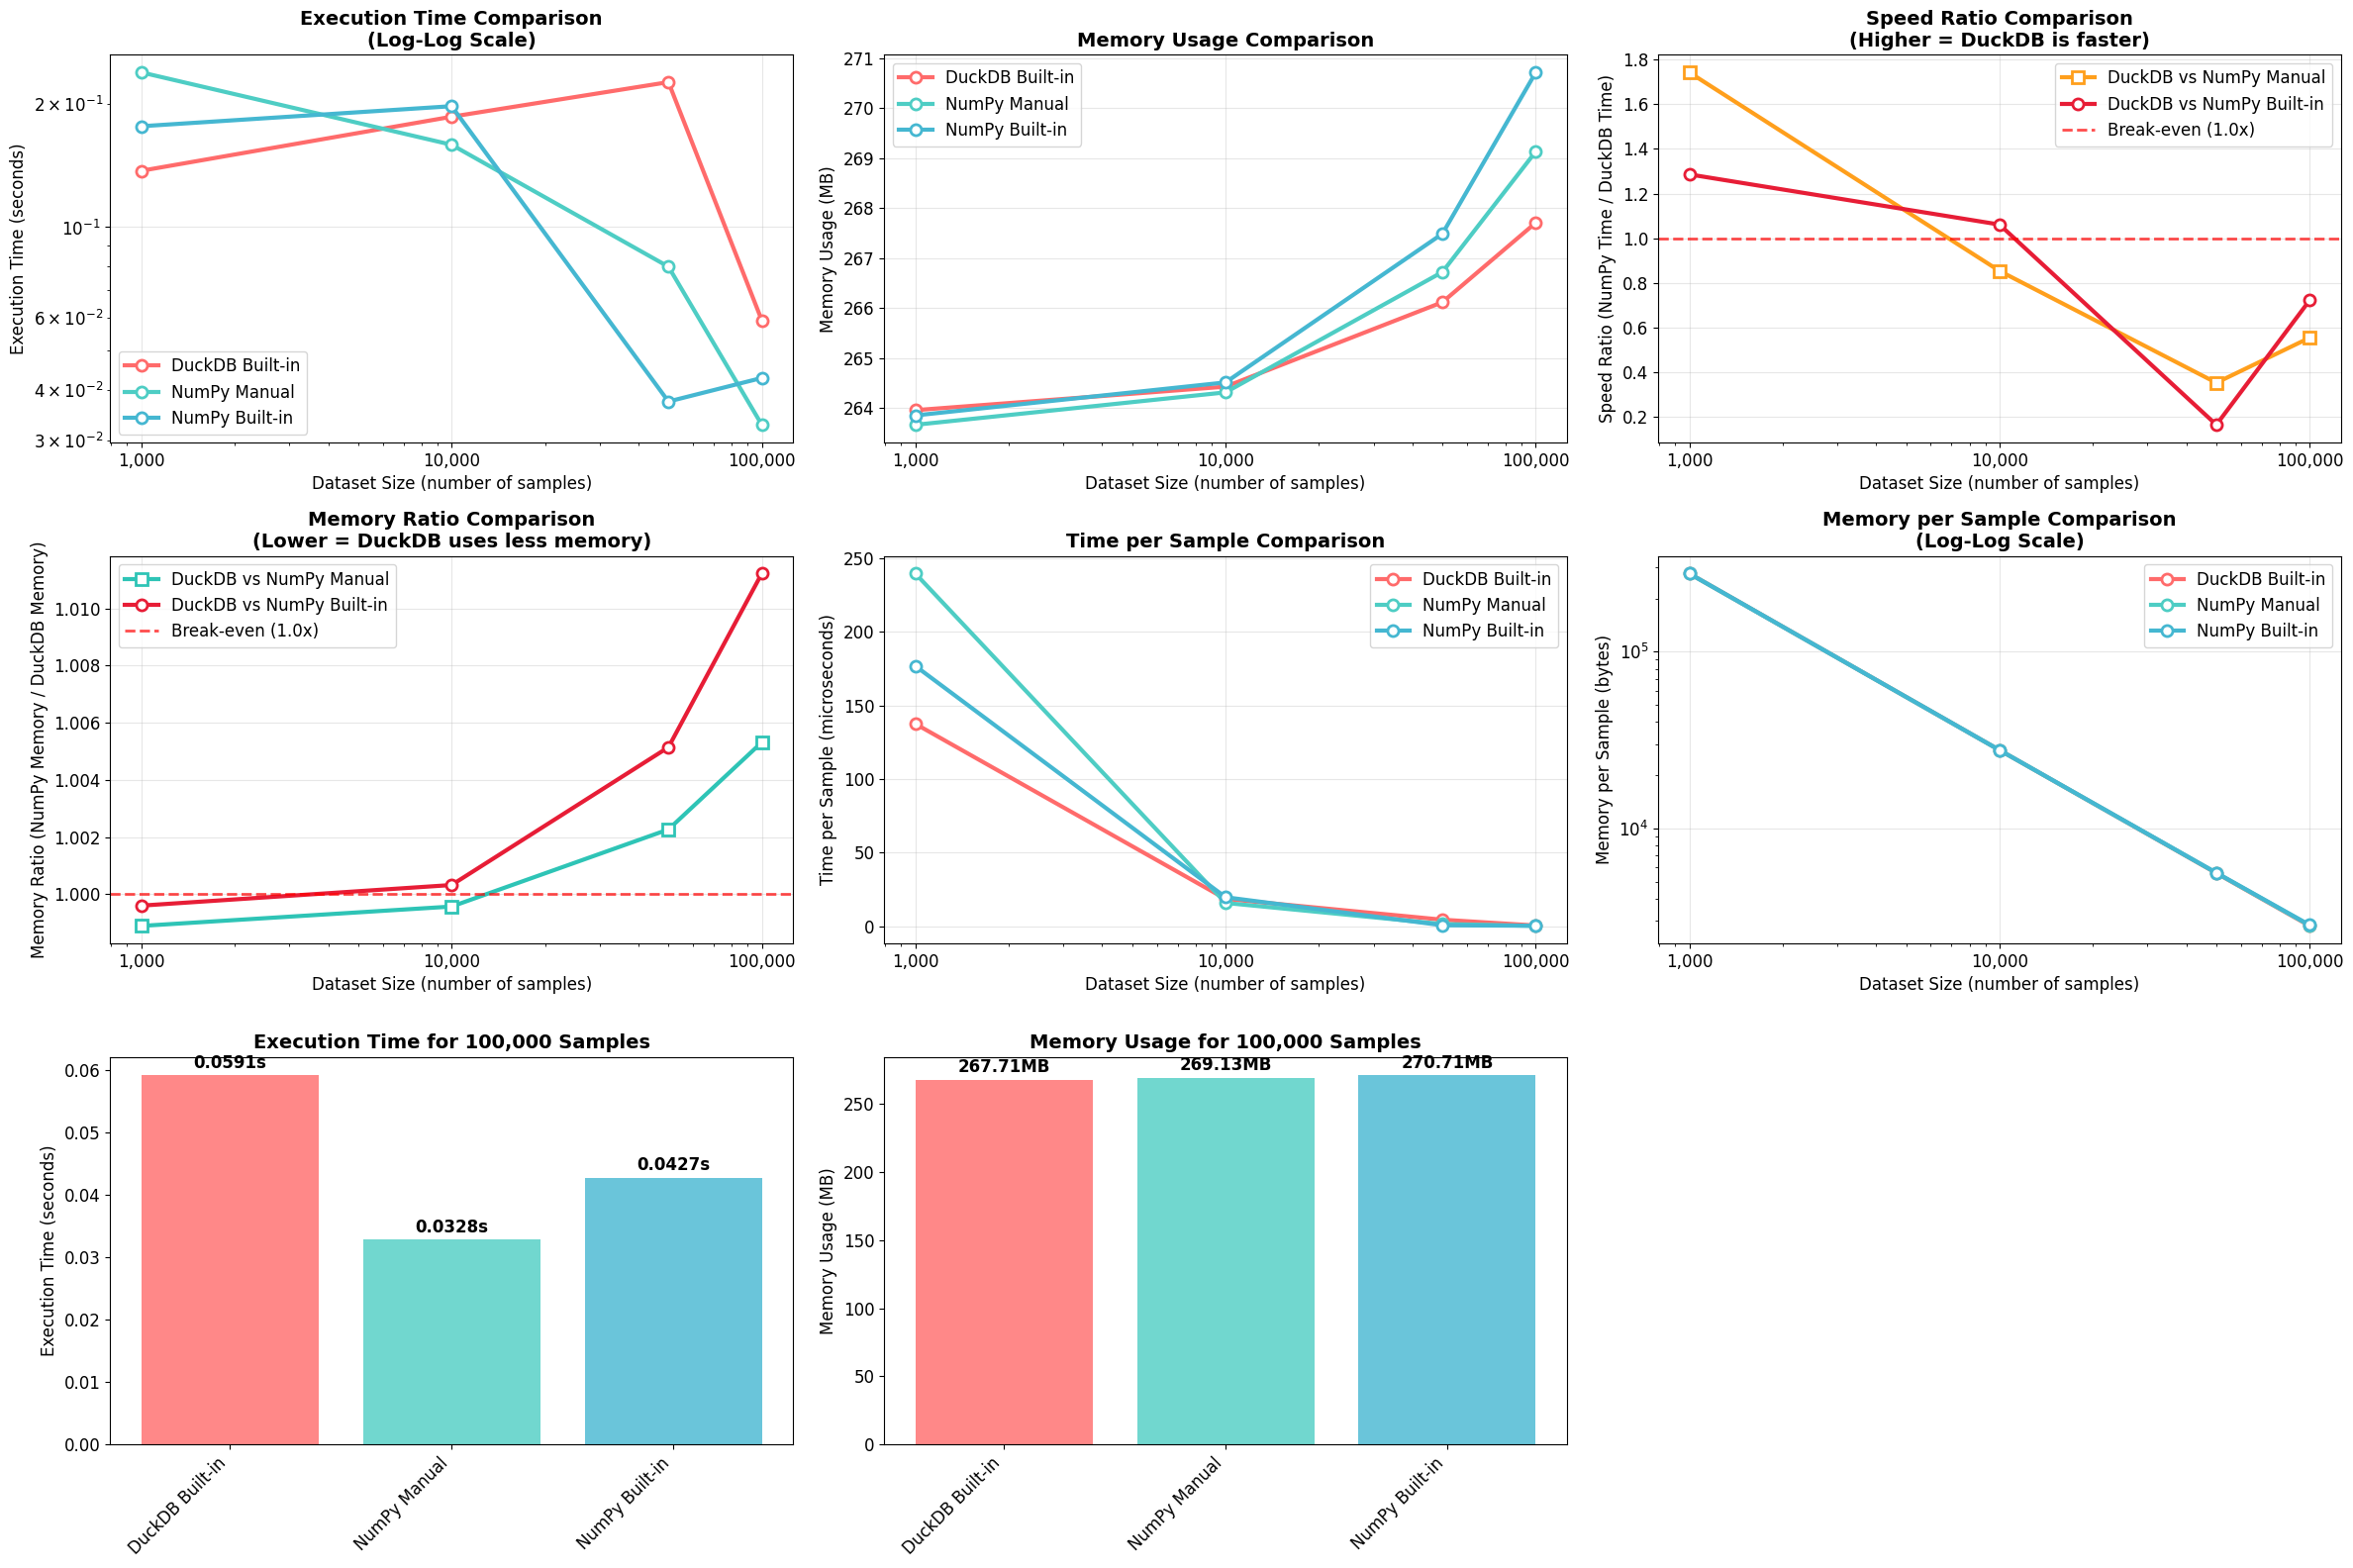


SUMMARY RESULTS TABLE
   Dataset Size   DuckDB (s)  NumPy-M (s)  NumPy-B (s)    Ratio-M    Ratio-B  DuckDB (MB) NumPy-M (MB) NumPy-B (MB)  Mem-Ratio-M  Mem-Ratio-B
------------------------------------------------------------------------------------------------------------------------------------------------------
          1,000     0.137485     0.239545     0.176778       1.74       1.29       263.96       263.66       263.85         1.00         1.00
         10,000     0.186530     0.159220     0.197941       0.85       1.06       264.43       264.31       264.51         1.00         1.00
         50,000     0.226748     0.080004     0.037380       0.35       0.16       266.12       266.72       267.48         1.00         1.01
        100,000     0.059092     0.032779     0.042703       0.55       0.72       267.71       269.13       270.71         1.01         1.01


In [3]:
import duckdb
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from memory_profiler import memory_usage

# Set up styling for professional-looking plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 12

def format_large_number(x, pos):
    """Format large numbers with commas"""
    return f'{x:,.0f}'

def benchmark_linear_regression(n_samples=100000):
    """Benchmark linear regression using DuckDB vs NumPy"""

    print(f" LINEAR REGRESSION BENCHMARK ({n_samples:,} samples)")
    print("=" * 70)

    # Generate sample data
    np.random.seed(42)
    X = np.random.rand(n_samples) * 10
    true_slope = 2.5
    true_intercept = 1.0
    y = true_slope * X + true_intercept + np.random.randn(n_samples) * 2.0

    df = pd.DataFrame({'x': X, 'y': y})

    # Benchmark results storage
    benchmarks = {
        'DuckDB Built-in': {'times': [], 'memory': [], 'results': None},
        'NumPy Manual': {'times': [], 'memory': [], 'results': None},
        'NumPy Built-in': {'times': [], 'memory': [], 'results': None}
    }

    # Benchmark 1: DuckDB Built-in Functions
    print("\n1.  DUCKDB BUILT-IN FUNCTIONS")
    print("-" * 50)

    for run in range(5):
        con = duckdb.connect()
        con.register('df', df)

        start_time = time.perf_counter()

        # Define the function to execute the query
        def execute_duckdb_query():
            return con.execute("""
            SELECT
                regr_slope(y, x) as slope,
                regr_intercept(y, x) as intercept,
                regr_r2(y, x) as r_squared,
                regr_count(y, x) as count,
                regr_sxx(y, x) as sxx,
                regr_syy(y, x) as syy,
                regr_sxy(y, x) as sxy
            FROM df
            """).fetchdf()

        # Measure memory usage
        mem_usage = memory_usage((execute_duckdb_query), max_usage=True, interval=0.01)
        result = execute_duckdb_query()

        end_time = time.perf_counter()
        benchmarks['DuckDB Built-in']['times'].append(end_time - start_time)
        benchmarks['DuckDB Built-in']['memory'].append(mem_usage)

        if run == 4:  # Store last result
            benchmarks['DuckDB Built-in']['results'] = result

        con.close()

    duckdb_avg_time = np.mean(benchmarks['DuckDB Built-in']['times'][1:])
    duckdb_avg_memory = np.mean(benchmarks['DuckDB Built-in']['memory'][1:])
    duckdb_result = benchmarks['DuckDB Built-in']['results']

    print(f"   Slope: {duckdb_result['slope'].iloc[0]:.6f} (true: {true_slope})")
    print(f"   Intercept: {duckdb_result['intercept'].iloc[0]:.6f} (true: {true_intercept})")
    print(f"   R²: {duckdb_result['r_squared'].iloc[0]:.6f}")
    print(f"   Time: {duckdb_avg_time:.6f} seconds ({duckdb_avg_time/n_samples * 1e6:.3f} μs/sample)")
    print(f"   Memory: {duckdb_avg_memory:.2f} MB")

    # Benchmark 2: NumPy Manual Calculation
    print("\n2.  NUMPY MANUAL CALCULATION")
    print("-" * 50)

    for run in range(5):
        start_time = time.perf_counter()

        # Measure memory usage
        def numpy_manual_calc():
            # Manual calculation
            x_mean = np.mean(X)
            y_mean = np.mean(y)
            numerator = np.sum((X - x_mean) * (y - y_mean))
            denominator = np.sum((X - x_mean) ** 2)
            slope_np = numerator / denominator
            intercept_np = y_mean - slope_np * x_mean
            y_pred = slope_np * X + intercept_np
            ss_res = np.sum((y - y_pred) ** 2)
            ss_tot = np.sum((y - y_mean) ** 2)
            r_squared_np = 1 - (ss_res / ss_tot)
            return {'slope': slope_np, 'intercept': intercept_np, 'r_squared': r_squared_np}

        mem_usage = memory_usage((numpy_manual_calc), max_usage=True, interval=0.01)
        result = numpy_manual_calc()

        end_time = time.perf_counter()
        benchmarks['NumPy Manual']['times'].append(end_time - start_time)
        benchmarks['NumPy Manual']['memory'].append(mem_usage)

        if run == 4:
            benchmarks['NumPy Manual']['results'] = result

    numpy_manual_avg_time = np.mean(benchmarks['NumPy Manual']['times'][1:])
    numpy_manual_avg_memory = np.mean(benchmarks['NumPy Manual']['memory'][1:])
    numpy_manual_result = benchmarks['NumPy Manual']['results']

    print(f"   Slope: {numpy_manual_result['slope']:.6f}")
    print(f"   Intercept: {numpy_manual_result['intercept']:.6f}")
    print(f"   R²: {numpy_manual_result['r_squared']:.6f}")
    print(f"   Time: {numpy_manual_avg_time:.6f} seconds ({numpy_manual_avg_time/n_samples * 1e6:.3f} μs/sample)")
    print(f"   Memory: {numpy_manual_avg_memory:.2f} MB")

    # Benchmark 3: NumPy with Built-in Functions
    print("\n3.  NUMPY WITH BUILT-IN FUNCTIONS")
    print("-" * 50)

    for run in range(5):
        start_time = time.perf_counter()

        # Measure memory usage
        def numpy_builtin_calc():
            # Using NumPy's built-in functions
            slope_np_builtin = np.cov(X, y, bias=True)[0, 1] / np.var(X)
            intercept_np_builtin = np.mean(y) - slope_np_builtin * np.mean(X)
            y_pred_builtin = slope_np_builtin * X + intercept_np_builtin
            r_squared_np_builtin = np.corrcoef(X, y)[0, 1] ** 2
            return {'slope': slope_np_builtin, 'intercept': intercept_np_builtin, 'r_squared': r_squared_np_builtin}

        mem_usage = memory_usage((numpy_builtin_calc), max_usage=True, interval=0.01)
        result = numpy_builtin_calc()

        end_time = time.perf_counter()
        benchmarks['NumPy Built-in']['times'].append(end_time - start_time)
        benchmarks['NumPy Built-in']['memory'].append(mem_usage)

        if run == 4:
            benchmarks['NumPy Built-in']['results'] = result

    numpy_builtin_avg_time = np.mean(benchmarks['NumPy Built-in']['times'][1:])
    numpy_builtin_avg_memory = np.mean(benchmarks['NumPy Built-in']['memory'][1:])
    numpy_builtin_result = benchmarks['NumPy Built-in']['results']

    print(f"   Slope: {numpy_builtin_result['slope']:.6f}")
    print(f"   Intercept: {numpy_builtin_result['intercept']:.6f}")
    print(f"   R²: {numpy_builtin_result['r_squared']:.6f}")
    print(f"   Time: {numpy_builtin_avg_time:.6f} seconds ({numpy_builtin_avg_time/n_samples * 1e6:.3f} μs/sample)")
    print(f"   Memory: {numpy_builtin_avg_memory:.2f} MB")

    # Comparison
    print("\n4.  COMPARISON RESULTS")
    print("-" * 50)

    speed_ratio_manual = numpy_manual_avg_time / duckdb_avg_time
    speed_ratio_builtin = numpy_builtin_avg_time / duckdb_avg_time

    memory_ratio_manual = numpy_manual_avg_memory / duckdb_avg_memory
    memory_ratio_builtin = numpy_builtin_avg_memory / duckdb_avg_memory

    print(f"    DuckDB vs NumPy (manual): {speed_ratio_manual:.2f}x {'faster' if speed_ratio_manual > 1 else 'slower'}")
    print(f"    DuckDB vs NumPy (built-in): {speed_ratio_builtin:.2f}x {'faster' if speed_ratio_builtin > 1 else 'slower'}")
    print(f"    DuckDB vs NumPy (manual): {memory_ratio_manual:.2f}x {'more' if memory_ratio_manual > 1 else 'less'} memory")
    print(f"    DuckDB vs NumPy (built-in): {memory_ratio_builtin:.2f}x {'more' if memory_ratio_builtin > 1 else 'less'} memory")

    return {
        'n_samples': n_samples,
        'benchmarks': benchmarks,
        'avg_times': {
            'DuckDB Built-in': duckdb_avg_time,
            'NumPy Manual': numpy_manual_avg_time,
            'NumPy Built-in': numpy_builtin_avg_time
        },
        'avg_memory': {
            'DuckDB Built-in': duckdb_avg_memory,
            'NumPy Manual': numpy_manual_avg_memory,
            'NumPy Built-in': numpy_builtin_avg_memory
        },
        'speed_ratios': {
            'manual': speed_ratio_manual,
            'builtin': speed_ratio_builtin
        },
        'memory_ratios': {
            'manual': memory_ratio_manual,
            'builtin': memory_ratio_builtin
        }
    }

def create_comparison_plots(results_dict, dataset_sizes):
    """Create comprehensive comparison plots"""

    fig = plt.figure(figsize=(24, 16))

    # Prepare data for plotting
    methods = ['DuckDB Built-in', 'NumPy Manual', 'NumPy Built-in']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    times_data = {method: [] for method in methods}
    memory_data = {method: [] for method in methods}
    ratios_data = {'manual': [], 'builtin': []}
    memory_ratios_data = {'manual': [], 'builtin': []}

    for size in dataset_sizes:
        result = results_dict[size]
        for method in methods:
            times_data[method].append(result['avg_times'][method])
            memory_data[method].append(result['avg_memory'][method])
        ratios_data['manual'].append(result['speed_ratios']['manual'])
        ratios_data['builtin'].append(result['speed_ratios']['builtin'])
        memory_ratios_data['manual'].append(result['memory_ratios']['manual'])
        memory_ratios_data['builtin'].append(result['memory_ratios']['builtin'])

    # Plot 1: Execution Time Comparison
    ax1 = plt.subplot(3, 3, 1)
    for i, method in enumerate(methods):
        plt.plot(dataset_sizes, times_data[method], 'o-', color=colors[i],
                linewidth=3, markersize=8, label=method, markerfacecolor='white', markeredgewidth=2)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Dataset Size (number of samples)')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Execution Time Comparison\n(Log-Log Scale)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_large_number))

    # Plot 2: Memory Usage Comparison
    ax2 = plt.subplot(3, 3, 2)
    for i, method in enumerate(methods):
        plt.plot(dataset_sizes, memory_data[method], 'o-', color=colors[i],
                linewidth=3, markersize=8, label=method, markerfacecolor='white', markeredgewidth=2)

    plt.xscale('log')
    plt.xlabel('Dataset Size (number of samples)')
    plt.ylabel('Memory Usage (MB)')
    plt.title('Memory Usage Comparison', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_large_number))

    # Plot 3: Speed Ratio Comparison
    ax3 = plt.subplot(3, 3, 3)
    plt.plot(dataset_sizes, ratios_data['manual'], 's-', color='#FF9F1C',
            linewidth=3, markersize=8, label='DuckDB vs NumPy Manual', markerfacecolor='white', markeredgewidth=2)
    plt.plot(dataset_sizes, ratios_data['builtin'], 'o-', color='#E71D36',
            linewidth=3, markersize=8, label='DuckDB vs NumPy Built-in', markerfacecolor='white', markeredgewidth=2)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Break-even (1.0x)')

    plt.xscale('log')
    plt.xlabel('Dataset Size (number of samples)')
    plt.ylabel('Speed Ratio (NumPy Time / DuckDB Time)')
    plt.title('Speed Ratio Comparison\n(Higher = DuckDB is faster)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_large_number))

    # Plot 4: Memory Ratio Comparison
    ax4 = plt.subplot(3, 3, 4)
    plt.plot(dataset_sizes, memory_ratios_data['manual'], 's-', color='#2EC4B6',
            linewidth=3, markersize=8, label='DuckDB vs NumPy Manual', markerfacecolor='white', markeredgewidth=2)
    plt.plot(dataset_sizes, memory_ratios_data['builtin'], 'o-', color='#E71D36',
            linewidth=3, markersize=8, label='DuckDB vs NumPy Built-in', markerfacecolor='white', markeredgewidth=2)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Break-even (1.0x)')

    plt.xscale('log')
    plt.xlabel('Dataset Size (number of samples)')
    plt.ylabel('Memory Ratio (NumPy Memory / DuckDB Memory)')
    plt.title('Memory Ratio Comparison\n(Lower = DuckDB uses less memory)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_large_number))

    # Plot 5: Time per Sample
    ax5 = plt.subplot(3, 3, 5)
    time_per_sample = {}
    for method in methods:
        time_per_sample[method] = [time * 1e6 / size for time, size in zip(times_data[method], dataset_sizes)]
        plt.plot(dataset_sizes, time_per_sample[method], 'o-', color=colors[methods.index(method)],
                linewidth=3, markersize=8, label=method, markerfacecolor='white', markeredgewidth=2)

    plt.xscale('log')
    plt.xlabel('Dataset Size (number of samples)')
    plt.ylabel('Time per Sample (microseconds)')
    plt.title('Time per Sample Comparison', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_large_number))

    # Plot 6: Memory per Sample
    ax6 = plt.subplot(3, 3, 6)
    memory_per_sample = {}
    for method in methods:
        memory_per_sample[method] = [mem * 1024 * 1024 / size for mem, size in zip(memory_data[method], dataset_sizes)]
        plt.plot(dataset_sizes, memory_per_sample[method], 'o-', color=colors[methods.index(method)],
                linewidth=3, markersize=8, label=method, markerfacecolor='white', markeredgewidth=2)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Dataset Size (number of samples)')
    plt.ylabel('Memory per Sample (bytes)')
    plt.title('Memory per Sample Comparison\n(Log-Log Scale)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_large_number))

    # Plot 7: Bar chart for largest dataset - Time
    ax7 = plt.subplot(3, 3, 7)
    largest_size = dataset_sizes[-1]
    largest_times = [times_data[method][-1] for method in methods]

    bars = plt.bar(methods, largest_times, color=colors, alpha=0.8)
    plt.ylabel('Execution Time (seconds)')
    plt.title(f'Execution Time for {largest_size:,} Samples', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar, time_val in zip(bars, largest_times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(largest_times)*0.01,
                f'{time_val:.4f}s', ha='center', va='bottom', fontweight='bold')

    # Plot 8: Bar chart for largest dataset - Memory
    ax8 = plt.subplot(3, 3, 8)
    largest_memory = [memory_data[method][-1] for method in methods]

    bars = plt.bar(methods, largest_memory, color=colors, alpha=0.8)
    plt.ylabel('Memory Usage (MB)')
    plt.title(f'Memory Usage for {largest_size:,} Samples', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar, mem_val in zip(bars, largest_memory):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(largest_memory)*0.01,
                f'{mem_val:.2f}MB', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()

    # Save the figure and show it
    plt.savefig('linear_regression_benchmark.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create results table
    print("\n" + "="*150)
    print("SUMMARY RESULTS TABLE")
    print("="*150)
    print(f"{'Dataset Size':>15} {'DuckDB (s)':>12} {'NumPy-M (s)':>12} {'NumPy-B (s)':>12} {'Ratio-M':>10} {'Ratio-B':>10} "
          f"{'DuckDB (MB)':>12} {'NumPy-M (MB)':>12} {'NumPy-B (MB)':>12} {'Mem-Ratio-M':>12} {'Mem-Ratio-B':>12}")
    print("-"*150)

    for i, size in enumerate(dataset_sizes):
        duckdb_time = times_data['DuckDB Built-in'][i]
        numpy_m_time = times_data['NumPy Manual'][i]
        numpy_b_time = times_data['NumPy Built-in'][i]

        duckdb_mem = memory_data['DuckDB Built-in'][i]
        numpy_m_mem = memory_data['NumPy Manual'][i]
        numpy_b_mem = memory_data['NumPy Built-in'][i]

        print(f"{size:>15,} {duckdb_time:>12.6f} {numpy_m_time:>12.6f} {numpy_b_time:>12.6f} "
              f"{ratios_data['manual'][i]:>10.2f} {ratios_data['builtin'][i]:>10.2f} "
              f"{duckdb_mem:>12.2f} {numpy_m_mem:>12.2f} {numpy_b_mem:>12.2f} "
              f"{memory_ratios_data['manual'][i]:>12.2f} {memory_ratios_data['builtin'][i]:>12.2f}")

# Run a quick benchmark with plots
def run_quick_benchmark_with_plots():
    """Run a quick benchmark and show plots"""

    dataset_sizes = [1000, 10000, 50000, 100000]
    results_dict = {}

    print(" STARTING QUICK BENCHMARK WITH PLOTS")
    print("=" * 60)

    for size in dataset_sizes:
        print(f"\n BENCHMARKING {size:,} SAMPLES ")
        results_dict[size] = benchmark_linear_regression(size)
        print(f"✅ COMPLETED {size:,} SAMPLES\n")

    # Create comparison plots
    print(" GENERATING COMPARISON PLOTS...")
    create_comparison_plots(results_dict, dataset_sizes)

    return results_dict

# Run the quick benchmark with plots
if __name__ == "__main__":
    # This will run the benchmark and show plots
    results = run_quick_benchmark_with_plots()